In [1]:
# Import Libs
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
import cv2

# Show image
import IPython.display
import PIL.Image

In [2]:
# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
MODEL_FILE = './deploy.prototxt'
PRETRAINED = 'snapshots/split_iter_100000.caffemodel'

In [3]:
# load the model
caffe.set_mode_gpu()
caffe.set_device(0)
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
print ("successfully loaded classifier")

successfully loaded classifier


In [4]:
color_mat = [np.full((480, 640, 3),np.array([0, 0, 0]))]
color_map = [np.full((1,3), np.array([0,0,0]))]
for i in range(0, 18):
        temp_colour = np.random.choice(range(256), size=3)
        color_map.append(np.full((1, 3), temp_colour))
        example_mat = np.full((10, 10, 3), temp_colour)
#         print('color {} is'.format(i))
#         IPython.display.display(PIL.Image.fromarray(example_mat.astype(np.uint8)))
        color_mat.append(np.full((480, 640, 3), temp_colour))

In [5]:
a_mark = ["background","lane_solid_white","lane_broken_white","lane_double_white","lane_solid_yellow","lane_broken_yellow","lane_double_yellow","lane_broken_blue","lane_slow","stop_line","arrow_left","arrow_right","arrow_go_straight","arrow_u_turn","speed_bump","crossWalk","safety_zone","other_road_markings"]
b_num = [i for i in range(0,18)]          
class_num = dict(zip(b_num, a_mark))

In [86]:
# image_path = '/mnt/diska/VPGNet/VPGNet-DB-5ch/scene_1/20160512_1329_00/000001.png' # the image you want to see
# image_path = '/mnt/diska/VPGNet/VPGNet-DB-5ch/scene_1/20160512_1332_00/000001.png' # the image you want to see
# image_path = '/mnt/diska/VPGNet/VPGNet-DB-5ch/scene_1/20160512_1335_29/000001.png' # the image you want to see
# image_path = '/mnt/diska/VPGNet/VPGNet-DB-5ch/scene_1/20160518_1704_41/000001.png' # the image you want to see
# image_path = '/mnt/diska/VPGNet/VPGNet-DB-5ch/scene_1/20160808_1509_56/000001.png' # the image you want to see
# image_path = '/mnt/diska/VPGNet/VPGNet-DB-5ch/scene_1/20160808_1509_56/000271.png' # the image you want to see
# image_path = '/mnt/diska/VPGNet/VPGNet-DB-5ch/scene_1/20160808_1425_16/000181.png' # the image you want to see
image_path = '/mnt/diska/VPGNet/VPGNet-DB-5ch/scene_3/20160503_0945_43/000121.png' # the image you want to see

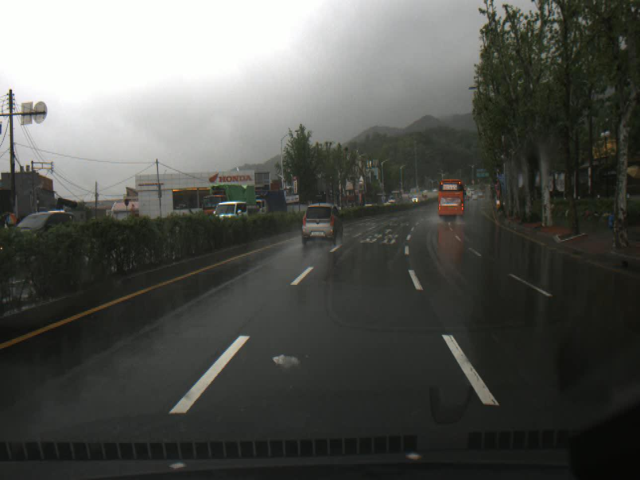

In [87]:
mask_path = image_path.replace(".png","_mask.png") # the masked image (generated by gen_label_v4.py)
image = cv2.imread(image_path) # read image
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # for cv2.imread, it reads in BGR so change to RGB
IPython.display.display(PIL.Image.fromarray(image)) # show image

# # Show Mask Image （Pre-generated）
# mask_im = cv2.imread(mask_path) # read masked image
# mask_im = cv2.cvtColor(mask_im, cv2.COLOR_RGB2BGR) # also, exchange the position for R and B
# IPython.display.display(PIL.Image.fromarray(mask_im)) # show masked image

In [88]:
# Test on Image
test_img = caffe.io.load_image(image_path)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2, 1, 0))
transformed_img = transformer.preprocess('data', test_img) # swap R, B channel, the final input to the network should be RGB
net.blobs['data'].data[...] = transformed_img

net.forward()


{'binary-mask': array([[[[9.99664664e-01, 9.99736011e-01, 9.99681592e-01, ...,
           9.99984145e-01, 9.99978185e-01, 9.99979019e-01],
          [9.99763072e-01, 9.99810994e-01, 9.99772370e-01, ...,
           9.99987483e-01, 9.99983311e-01, 9.99983191e-01],
          [9.99789059e-01, 9.99835968e-01, 9.99801219e-01, ...,
           9.99988198e-01, 9.99985099e-01, 9.99984145e-01],
          ...,
          [9.99925971e-01, 9.99945402e-01, 9.99936461e-01, ...,
           9.99887347e-01, 9.99832630e-01, 9.99858975e-01],
          [9.99924779e-01, 9.99942660e-01, 9.99935150e-01, ...,
           9.99877572e-01, 9.99815404e-01, 9.99847054e-01],
          [9.99911785e-01, 9.99929905e-01, 9.99922156e-01, ...,
           9.99842286e-01, 9.99752700e-01, 9.99791324e-01]],
 
         [[3.35304387e-04, 2.63953320e-04, 3.18442209e-04, ...,
           1.58528419e-05, 2.18048463e-05, 2.09736136e-05],
          [2.36958120e-04, 1.88998092e-04, 2.27658791e-04, ...,
           1.24576954e-05, 1.665272

In [89]:
#Binary Mask blob masking
obj_mask = net.blobs['binary-mask'].data # object mask: detect whether have obj
mlabel = net.blobs['multi-label'].data # mlabel: saves 18 feature maps for different classes
bbox = net.blobs['bb-output-tiled'].data # bbox: not sure

In [90]:
image = cv2.imread(image_path) # read image
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # for cv2.imread, it reads in BGR so change to RGB

In [91]:
from scipy.io import loadmat

# Generate 480*640*3 image with 
def generate_labeled_image(row_image, pixel_labels, color_mat, classes = 17):
    # Pixel_labels have to be 480*640*1 rather than 480*640*1
    labels = pixel_labels # WARNING: only designed for 480*640 for optimization for running
    labels = np.concatenate((labels, labels, labels), axis = 2).astype(np.uint8)
    temp_im = row_image
    for i in range(1, classes + 1): # from class 1 to max class
        temp_im = np.where(labels == np.array([i, i, i]), color_mat[i+1], temp_im)
    return temp_im.astype(np.uint8)

mat_path = image_path.replace(".png",".mat") # the masked image (generated by gen_label_v4.py)
mat_file = loadmat(mat_path)
rgb_seg_vp_label = mat_file['rgb_seg_vp']
seg_label = rgb_seg_vp_label[:, :, 3].reshape(480,640,1)

class lane_broken_white detected with color


class lane_solid_yellow detected with color


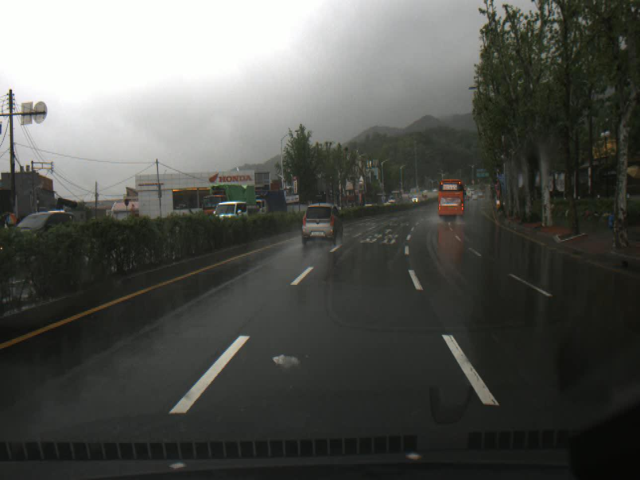

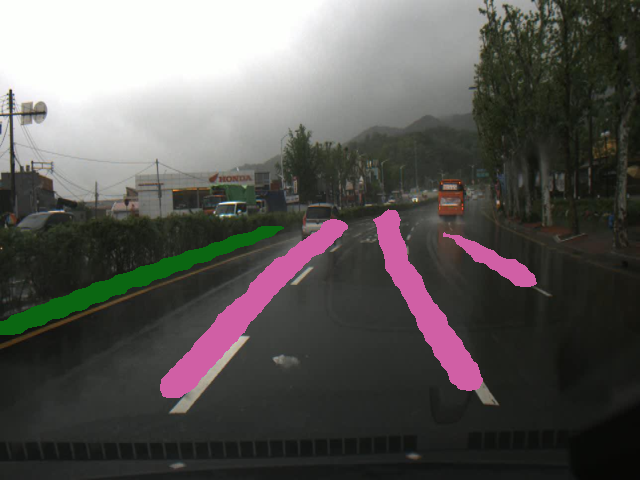

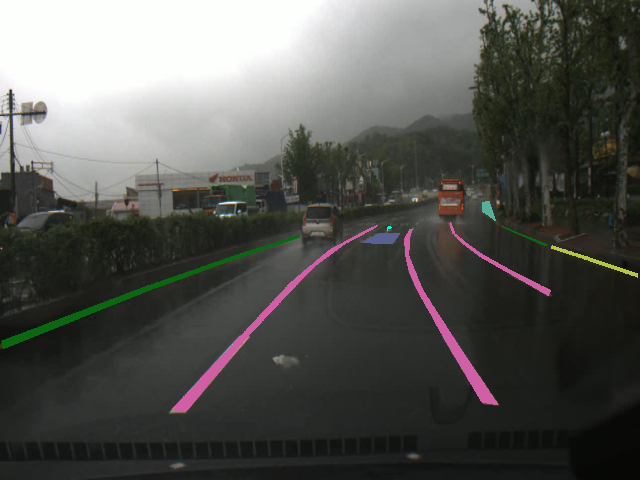

In [94]:
alpha = 1
mix_im = image
for i in range(1, 18):
    small_mask = mlabel[0, i, ...] * 255 # normalize from (0,1) to (0,255)
    resized_mask = cv2.resize(small_mask, (640, 480))
    imggray = resized_mask.astype('uint8')
    sensitivity = 150
    ret,thresh = cv2.threshold(imggray,sensitivity, 255, cv2.THRESH_BINARY) # do binarize: if higher than 'sensitivity', set as 1; otherwise set as 0
    thresh = thresh.reshape(480, 640, 1).astype(np.uint8)
    if 255 in thresh:
        print("class {} detected with color".format(class_num[i-1]))
        example_mat = np.full((10, 10, 3), color_map[i])
        IPython.display.display(PIL.Image.fromarray(example_mat.astype(np.uint8)))
    labels = np.concatenate((thresh, thresh, thresh), axis = 2).astype(np.uint8)
    temp_im = mix_im
    temp_im = np.where(labels == np.array([255, 255, 255]), color_mat[i], temp_im).astype(np.uint8)
    mix_im = cv2.addWeighted(temp_im, alpha, image, 1 - alpha, 0)

IPython.display.display(PIL.Image.fromarray(image))
IPython.display.display(PIL.Image.fromarray(mix_im))
mixed_im = generate_labeled_image(image, seg_label, color_mat)
mixed_im = cv2.addWeighted(mixed_im, alpha, image, 1 - alpha, 0)
IPython.display.display(PIL.Image.fromarray(mixed_im)) # show masked image

In [ ]:
255 in labels

In [ ]:
print("ground truth")
IPython.display.display(PIL.Image.fromarray(seg_label.astype(np.bool))) # groundtruth image, from seg_label

ch = 15 # select which channel you want to see. E.g. to see safe zoon should be 15
small_mask = mlabel[0, ch, ...] * 255 # normalize from (0,1) to (0,255)
resized_mask = cv2.resize(small_mask, (640, 480))
o_image = resized_mask.astype('uint8')
print("predicted feature map")
IPython.display.display(PIL.Image.fromarray(o_image)) # show predicted feature map

imggray = o_image
sensitivity = 10
ret,thresh = cv2.threshold(imggray,sensitivity, 255, cv2.THRESH_BINARY) # do binarize: if higher than 'sensitivity', set as 1; otherwise set as 0
print("after binarize over threshold {}".format(sensitivity))
IPython.display.display(PIL.Image.fromarray(thresh)) # Show image after binarization

In [ ]:
test_map = np.zeros((480,640,18)).astype(np.uint8)
for i in range(0,18):
    small_mask = mlabel[0, i, ...] * 255 # normalize from (0,1) to (0,255)
    resized_mask = cv2.resize(small_mask, (640, 480))
    imggray = resized_mask.astype('uint8')
    sensitivity = 10
    ret,thresh = cv2.threshold(imggray,sensitivity, 255, cv2.THRESH_BINARY) # do binarize: if higher than 'sensitivity', set as 1; otherwise set as 0
    test_map[:,:,i] = thresh

In [ ]:
for i in range(0,18):
    IPython.display.display(PIL.Image.fromarray(test_map[:,:,i])) # Show image after binarization

In [ ]:
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # draw contour on the binarized output map
cv2.drawContours(imggray, contours, -1, (255,255,255), 3)
print("draw contour on feature map")
IPython.display.display(PIL.Image.fromarray(imggray))

image = cv2.imread(image_path) # read image
# net.blobs['data'].reshape(1, image.shape[2], image.shape[0], image.shape[1])
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # for cv2.imread, it reads in BGR so change to RGB
cv2.drawContours(image, contours, -1, (255,0,0), 3)# drow contour on original image
print("draw contour on original image")
IPython.display.display(PIL.Image.fromarray(image))